In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Tue Dec 11 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
# %matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-2-a857d1235d28>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [202]:
meta_df['SEX'] = meta_df['SEX'].astype('category')
print("Women: %s " % len(meta_df['SEX'][meta_df['SEX']==0]))
print("Men: %s " % len(meta_df['SEX'][meta_df['SEX']==1]))
print("Age: \n%s" % meta_df['AGE'].describe())
print('250 Hz: %s \t 1000 Hz: %s' % (len(meta_df[meta_df['freq']==250]),len(meta_df[meta_df['freq']==1000])))

Women: 104 
Men: 29 
Age: 
count    133.000000
mean      47.706767
std        9.577263
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: AGE, dtype: float64
250 Hz: 99 	 1000 Hz: 34


In [24]:
def prepare_dfs(col='lyap', kind='processed'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'training_{col}.pkl')) 
    df_bef = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'{col}_bef.pkl'))
    df_aft = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'{col}_aft.pkl'))
    return df, df_bef, df_aft
    
def prepare_resp_non(col='lyap'):
    df, df_bef, df_aft = prepare_dfs(col)
    return df[df['change'] >= df.quantile(0.66)['change']], df[df['change'] <= df.quantile(0.33)['change']]

df, df_bef, df_aft = prepare_dfs('lyap')
df_resp, df_non = prepare_resp_non('lyap')
df_non

FP1        FP2         F3         F4         C3  \
patient trial                                                          
2       a      11.024046  10.931383  10.983798  10.579523  11.152647   
        b      10.890927  10.180207  10.533803  10.616531   9.175582   
4       a      11.037301  11.244759  10.770227  11.199896  10.773018   
        b      10.739284  11.094095  10.486669  10.819649  10.166096   
5       a      10.599686  10.422060   9.956673   9.774134   9.767138   
        b      10.174072  10.334184   9.833406   9.406006   9.434635   
7       a      10.563732  10.141768  10.587910  10.404398  10.888080   
        b      11.339571  11.032791  11.340681  10.930443  11.354266   
9       a      10.409244  10.255253  10.627625  10.409508  10.037384   
        b      10.795386  10.831201  10.618768  10.641907  10.323936   
11      a       9.895114  10.672720   9.945693  10.236120  10.216926   
        b       9.510861   9.935302   8.065521   9.447164   7.217220   
16      a       9.829509  10.158299  10.563651  10.466694  11.141658   
        b      10.169330  10.371962  10.558436  10.467222  10.794234   
19      a      10.388878  10.388119  10.753497  11.132665  11.091010   
        b      11.159137  10.961169  10.870288  10.514768  11.215308   
22      a      11.562811  11.255257   9.764855  11.270170  10.348361   
        b      10.600998  10.360244   9.507643   9.206352   9.021949   
24      a      10.246208   8.593929   8.749961   9.210889   9.928819   
        b       8.362841   8.033764   7.522076   7.252267   8.219302   
27      a      10.920017  10.829911  11.272298  11.511025  11.212657   
        b      10.948189  10.455997  10.746887   9.936060  10.657562   
29      a       7.448230   8.668804   8.512729   8.619707   8.560145   
        b       8.033177   9.566567   9.246619   7.784361   9.479568   
31      a      10.767793   9.962427  10.513834   8.762583  10.595295   
        b      10.380356  10.481717   9.959035   9.683118   9.133884   
37      a      10.453217  10.893287  10.438552  10.437996  10.591203   
        b      10.833398  10.455178  10.609556  10.369222  10.784990   
45      a       8.389277   8.975336   9.748781   8.832909  10.617822   
        b       8.924895  10.352525  10.883374   8.989128  10.073432   
...                  ...        ...        ...        ...        ...   
81      a      11.188261  11.129031  11.058684   9.946252  10.841252   
        b       9.951440  11.177321  10.746975  10.685323  10.932927   
83      a      12.957956  12.602884  12.665269  12.644601  10.922954   
        b       9.442413  11.631556   9.387506   9.633188   7.973511   
85      a      11.257896  11.222196  11.054652  10.901996  11.214981   
        b      11.332459  11.414306  11.933237  12.226741  11.845873   
87      a      10.159974  10.581144  10.277945   9.423564   9.308353   
        b       8.756991   8.233339   8.924678   7.395096   8.483654   
88      a       9.151984   9.225348  10.546110  10.132086  10.085278   
        b      11.606664  11.662925  11.108919  11.553807  10.776319   
89      a       7.138677   7.296222   6.773885   7.246077   7.495904   
        b       6.505318   7.586598   7.125123   7.696597   7.566208   
94      a       8.806179   9.508266   9.926100  10.080973  10.445062   
        b       7.936906   8.560883   9.380280   9.237349   9.570727   
99      a       8.511321   8.516064   9.075224   7.802205  10.046136   
        b       8.350793   8.507980   9.336389   8.488633   9.711445   
110     a      11.122391  11.768860  10.630354  10.946324   9.858068   
        b      10.433915  11.003199  10.117788  10.569070  10.080745   
113     a       8.610079   8.355738   8.935205   7.043615   7.875272   
        b       8.509747   8.004563   9.076291   6.896262   7.421605   
121     a      10.545034  10.381886  10.659161  10.399173   9.101062   
        b       7.154413   9.065500   9.642812  10.393235   9.547033   
123     a      10.569209  11.288571  10.994878  11.386394  10

# Before and after comparison plots

<IPython.core.display.Javascript object>


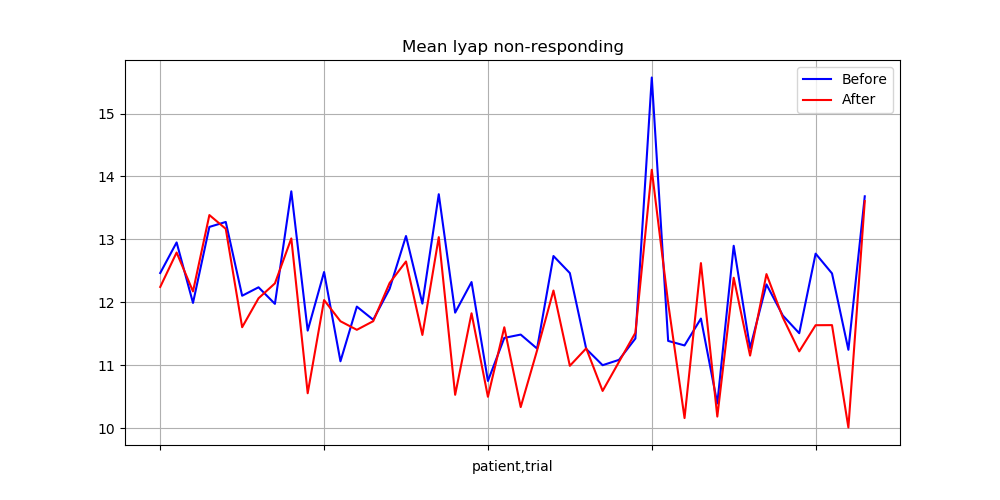

<IPython.core.display.Javascript object>


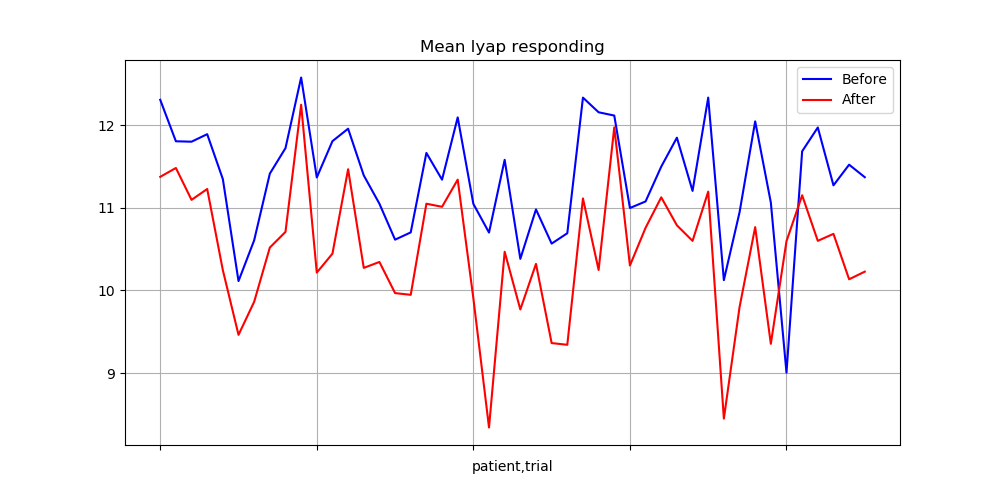

<IPython.core.display.Javascript object>


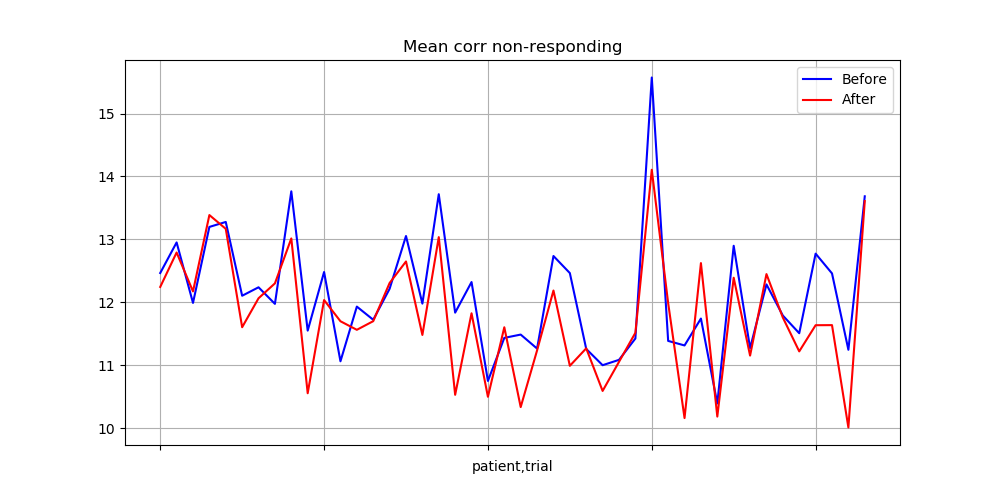

<IPython.core.display.Javascript object>


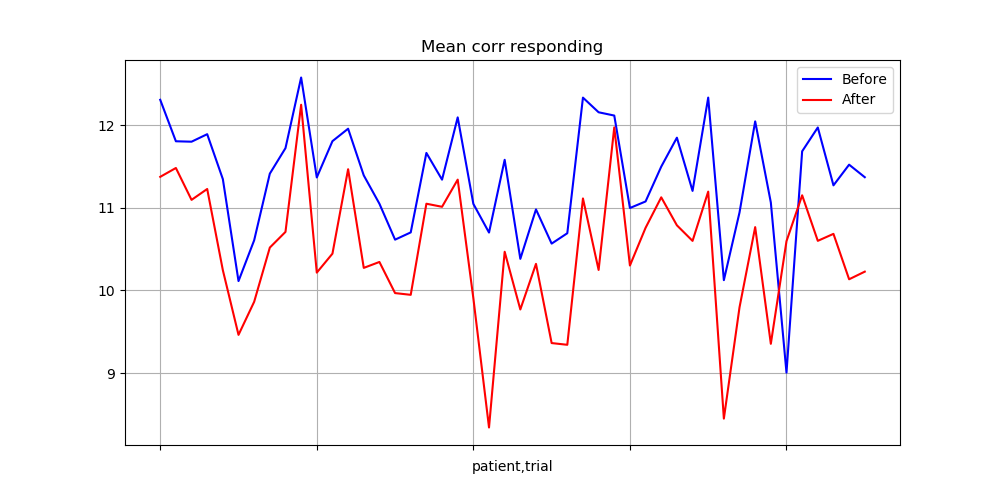

<IPython.core.display.Javascript object>


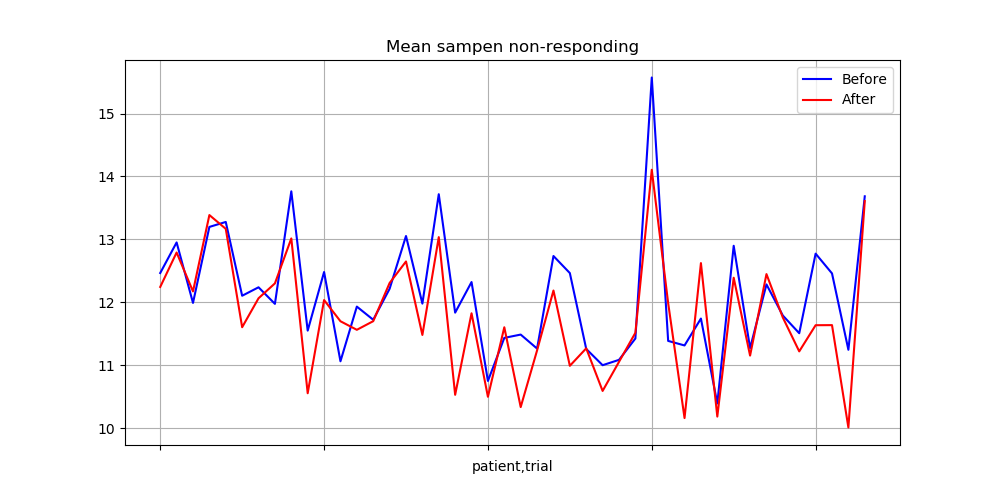

<IPython.core.display.Javascript object>


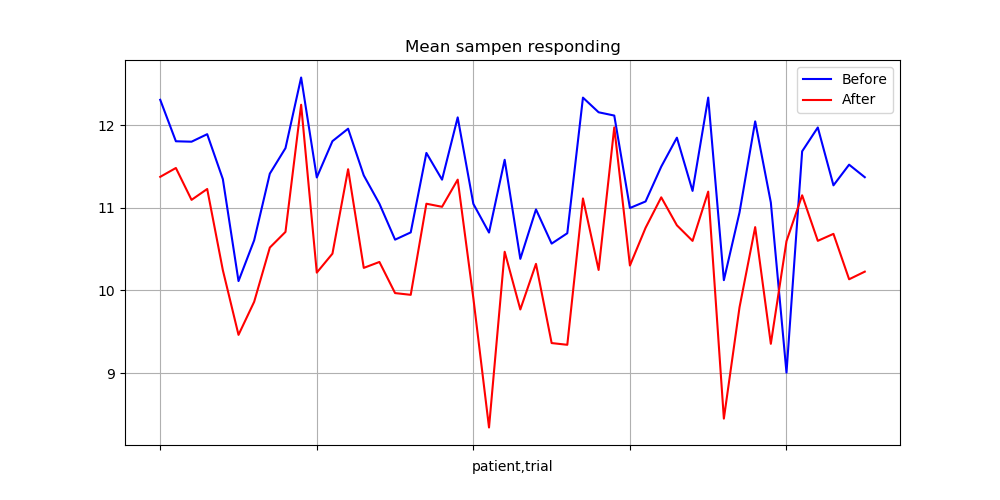

<IPython.core.display.Javascript object>


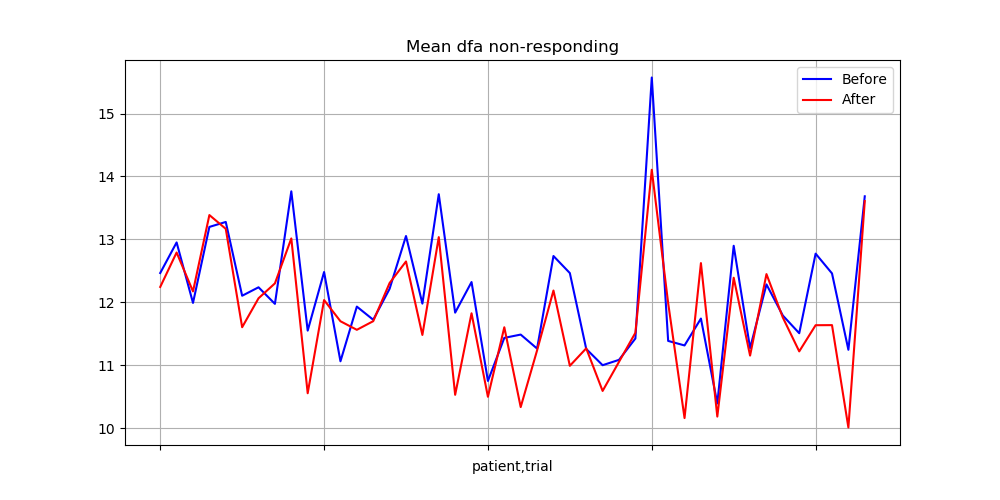

<IPython.core.display.Javascript object>


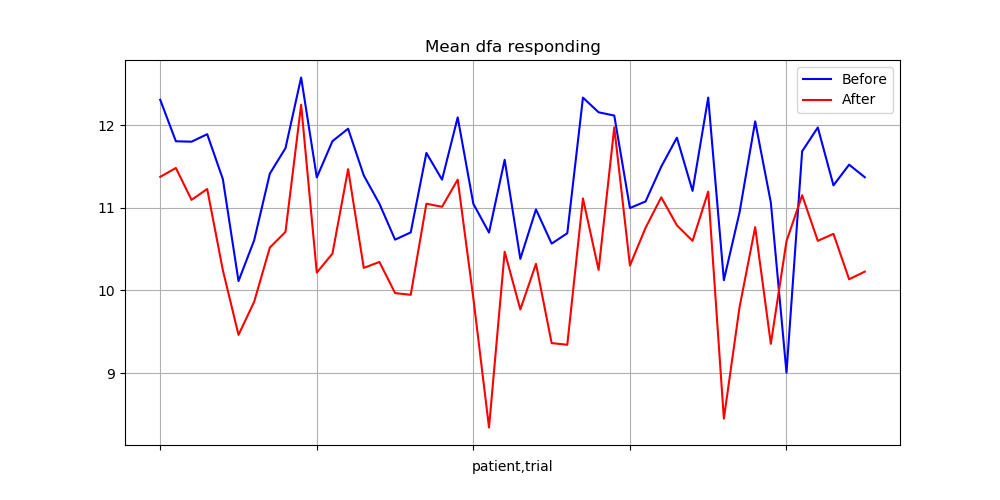

In [6]:
def plot_resp(df_bef, df_aft, m_name, resp, quantiles=False):
    if quantiles and resp:
        means_bef = df_resp.loc[(slice(None), 'a'), :].mean(axis=1)
        means_aft = df_resp.loc[(slice(None), 'b'), :].mean(axis=1)
    elif quantiles and not resp:
        means_bef = df_non.loc[(slice(None), 'a'), :].mean(axis=1)
        means_aft = df_non.loc[(slice(None), 'b'), :].mean(axis=1)
    else:
        means_bef = df_bef[df_bef['resp']==resp].mean(axis=1)
        means_aft = df_aft[df_aft['resp']==resp].mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    # ax1.set_ylim([8,13])
    # ax2.set_ylim([8,13])
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0, True)
    plot_resp(df_bef, df_aft, m_name, 1, True)

for col in ['lyap', 'corr', 'sampen', 'dfa']:
    df, df_bef, df_aft = prepare_dfs(col)
    df_resp, df_non = prepare_resp_non('lyap')
    plot_measure(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :], col)
    # plot_measure(df_bef, df_aft, col)

# Before and after K-S test

In [38]:
from scipy.stats import ks_2samp

def print_res(name, res, mean1='', mean2=''):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {} \t {} \t {}'.format(name, res.pvalue, mean1, mean2, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef[CHANNEL_NAMES].mean(axis=1), df_aft[CHANNEL_NAMES].mean(axis=1)), 
              df_bef[CHANNEL_NAMES].mean(axis=1).mean(), df_aft[CHANNEL_NAMES].mean(axis=1).mean())
    print_res('Stds', ks_2samp(df_bef[CHANNEL_NAMES].std(axis=1), df_aft[CHANNEL_NAMES].std(axis=1)), 
              df_bef[CHANNEL_NAMES].std(axis=1).mean(), df_aft[CHANNEL_NAMES].std(axis=1).mean())
    for col in CHANNEL_NAMES:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]), df_bef[col].mean(), df_aft[col].mean())
        

for col in ['lyap', 'corr', 'sampen', 'dfa']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['resp']==0], df_aft[df_aft['resp']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['resp']==1], df_aft[df_aft['resp']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE ***')
for col in ['lyap', 'corr', 'sampen', 'dfa']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['sc'] <= df.quantile(0.33)['sc']]
    high = df[df['sc'] >= df.quantile(0.66)['sc']]
    channel_wise_ks(low, high)
    print()
    
print('*** RESPONDING / NON-RESPONDING - terciles ***')
for col in ['lyap', 'corr', 'sampen', 'dfa']:
    df_resp, df_non = prepare_resp_non(col)
    print(col.upper())
    print(len(df_resp.loc[(slice(None), 'a'), :]))
    print(len(df_non.loc[(slice(None), 'a'), :]))
    print(len(df_resp.loc[(slice(None), 'b'), :]))
    print(len(df_non.loc[(slice(None), 'b'), :]))
    print('resp/nonresp before treatment')
    channel_wise_ks(df_resp.loc[(slice(None), 'a'), :] , df_non.loc[(slice(None), 'a'), :])
    print('resp/nonresp after treatment')
    channel_wise_ks(df_resp.loc[(slice(None), 'b'), :] , df_non.loc[(slice(None), 'b'), :])

LYAP
All
Means: 	 0.12112271978338932 	 10.15095368533761 	 9.919065871281502 	 
Stds: 	 0.08948089585557518 	 0.6277901987686094 	 0.7240062461444231 	 
FP1: 	 0.4318757849532838 	 9.77031245479549 	 9.545060416657886 	 
FP2: 	 0.4318757849532838 	 9.763831647238373 	 9.564800134704457 	 
F3: 	 0.0650811225434144 	 9.793962842548328 	 9.49253905576706 	 !
F4: 	 0.01049009059441507 	 9.861753567959541 	 9.413233389201732 	 !!!
C3: 	 0.08948089585557518 	 9.846219495266565 	 9.578574214637602 	 
C4: 	 0.03285721179678041 	 9.921792831201753 	 9.598418178682746 	 !!
P3: 	 0.21167621640176998 	 10.447329553198438 	 10.291359719310913 	 
P4: 	 0.8321899922317654 	 10.437205545206718 	 10.26575092671367 	 
O1: 	 0.9648707886017801 	 10.539346841736853 	 10.48539242625017 	 
O2: 	 0.27314100870307295 	 10.518406263967188 	 10.408816018087222 	 
F7: 	 0.4318757849532838 	 10.095756669950285 	 9.886245722426057 	 
F8: 	 0.27314100870307345 	 10.117809065623833 	 9.785260852225408 	 
T3: 	 0.00

SAMPEN
All
Means: 	 0.23952735572819542 	 0.7614952421203219 	 0.7899615751124499 	 
Stds: 	 0.09437420582631723 	 0.07054528942074818 	 0.08564068932970437 	 
FP1: 	 0.40331693180924505 	 0.8042967106652867 	 0.8374109238787266 	 
FP2: 	 0.403316931809244 	 0.8020447025295782 	 0.8304407904851229 	 
F3: 	 0.17902368629316182 	 0.7996542740376574 	 0.8385738380464871 	 
F4: 	 0.046113263538343496 	 0.7895475052075592 	 0.8419703670157528 	 !!
C3: 	 0.31412090452959734 	 0.7926643483729102 	 0.824622557156189 	 
C4: 	 0.046113263538343496 	 0.7812687083949665 	 0.8213061546708815 	 !!
P3: 	 0.6185828173807629 	 0.7204613754704052 	 0.7395636097610586 	 
P4: 	 0.9750577553253461 	 0.719829483439618 	 0.7361016462417614 	 
O1: 	 0.7336458901692725 	 0.706795923261043 	 0.7178179644013479 	 
O2: 	 0.31412090452959734 	 0.7117338821515583 	 0.7315508756402814 	 
F7: 	 0.6185828173807629 	 0.7861738415958678 	 0.8109458601698188 	 
F8: 	 0.40331693180924505 	 0.780732536685879 	 0.8213015529

Stds: 	 0.9242999740774673 	 0.0822991497502822 	 0.07867048686207635 	 
FP1: 	 0.814886658223135 	 0.8397701039469674 	 0.8164971433270374 	 
FP2: 	 0.47503097779413433 	 0.8430401835112662 	 0.8053207385836046 	 
F3: 	 0.5703484033037354 	 0.8428564795502892 	 0.8165355670178184 	 
F4: 	 0.2153681932061187 	 0.83938746794146 	 0.8015210340771479 	 
C3: 	 0.814886658223135 	 0.8206460548931076 	 0.8192985909050685 	 
C4: 	 0.06818323665115347 	 0.82422399827703 	 0.794242385298626 	 !
P3: 	 0.4888549673500837 	 0.7373099293637887 	 0.7298824135140412 	 
P4: 	 0.2811909315486513 	 0.7400718819441091 	 0.7193180441742636 	 
O1: 	 0.7103200804868247 	 0.7169369483755653 	 0.7211882029841168 	 
O2: 	 0.06112064562193268 	 0.7238624699279154 	 0.7211313650369314 	 !
F7: 	 0.9213059245882118 	 0.8058768906795052 	 0.8162363266767092 	 
F8: 	 0.9529881470242786 	 0.81137741212867 	 0.8122579324169972 	 
T3: 	 0.4569045937743267 	 0.853715268393703 	 0.8388292721005419 	 
T4: 	 0.388242815618

T4: 	 0.26374338634462957 	 0.8856732483437277 	 0.88676155426135 	 
T5: 	 0.19307603677875523 	 0.7621552087060668 	 0.7471861563884871 	 
T6: 	 0.0017069177282416944 	 0.7516296101482004 	 0.7213927366059601 	 !!!
Fz: 	 0.11168103957009515 	 0.7819226318915091 	 0.7574439048681978 	 
Cz: 	 0.05626886162167754 	 0.7831252406641467 	 0.7566530067376048 	 !
Pz: 	 0.10386616680647372 	 0.7423629363541511 	 0.7298241450136423 	 
DFA
41
37
41
37
resp/nonresp before treatment
Means: 	 0.23931021771306946 	 0.5547870804445574 	 0.5164484264068948 	 
Stds: 	 0.4934790340789623 	 0.1313162087598596 	 0.1382555067988608 	 
FP1: 	 0.3516061360698058 	 0.6674949813393787 	 0.6418572936294513 	 
FP2: 	 0.8514082487146687 	 0.6643707385146519 	 0.6448026472886849 	 
F3: 	 0.08826225621320388 	 0.5658543536558533 	 0.5161521892733086 	 
F4: 	 0.8472560184255141 	 0.5451465479353989 	 0.5473872685145302 	 
C3: 	 0.8472560184255141 	 0.522462179376555 	 0.5055532487510057 	 
C4: 	 0.1499617899756621 	

# PCA

<IPython.core.display.Javascript object>


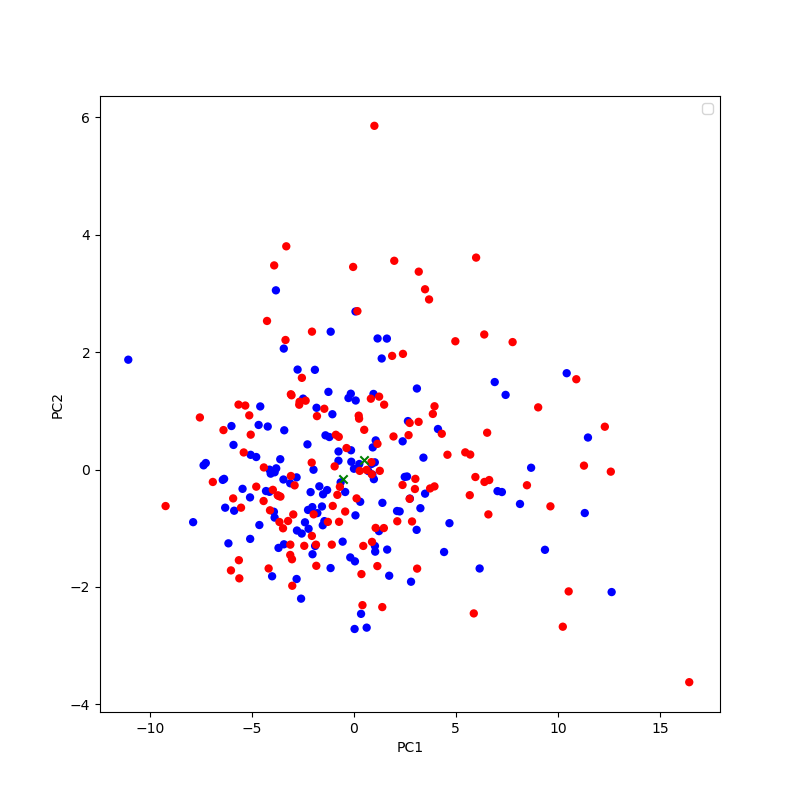

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


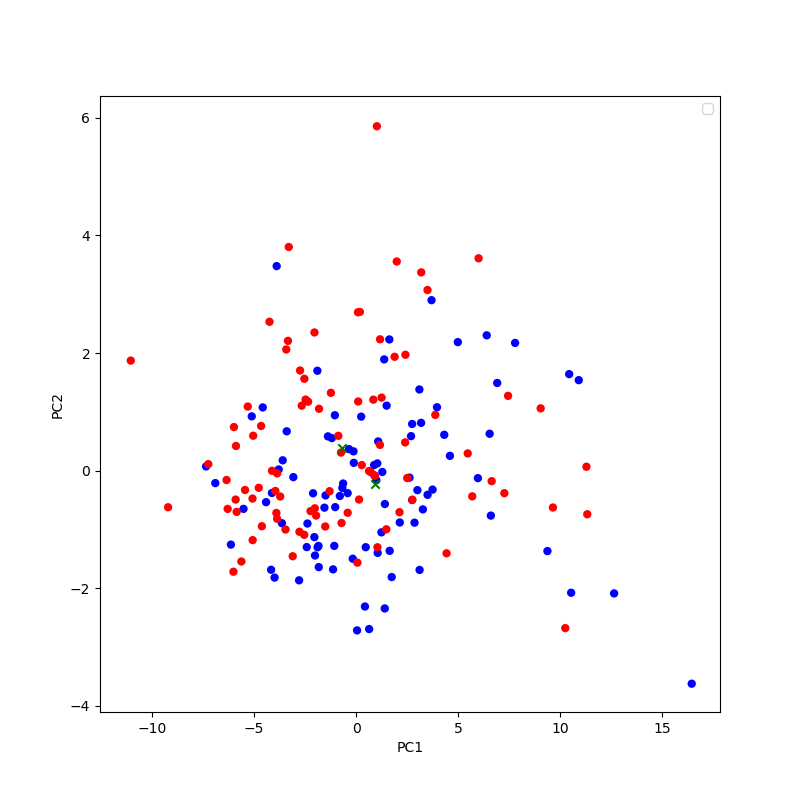

No handles with labels found to put in legend.


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def plot_pca_2d(df_first, df_second=None, c1='blue', c2='red', title=""):
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(first[:,0], first[:,1], c=c1, cmap='Blues', edgecolors='', label='')
    plt.scatter(np.average(first[:,0]), np.average(first[:,1]), c='g', marker='x')
    if second is not None:
        plt.scatter(second[:,0], second[:,1], c=c2, cmap='Reds', edgecolors='', label='')
        plt.scatter(np.average(second[:,0]), np.average(second[:,1]), c='g', marker='x')
    # plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)
pca = decomposition.PCA(n_components=2)
pca.fit(df[CHANNEL_NAMES])

plot_pca_2d(df_bef, df_aft, title="Before / After")
# plot_pca_2d(df, None, c1=df['change'], title="Change in score")
# plot_pca_2d(df_bef, None, c1=df_bef['sc_bef'], title="")
# plot_pca_2d(df_aft, None, c1=df_aft['sc_aft'], title="")
# plot_pca_2d(df_aft[df_aft['sc_aft'] > 27], c1='red', title="")
# plot_pca_2d(df_bef[df_bef['sc_bef'] > 30], title="")
# plot_pca_2d(df[(df['sc']>30) & (df['sc']>30)], df[(df['sc'] < 20) & (df['sc'] < 20)], title="Depressed / Non-depressed")
# plot_pca_2d(df[df['sc'] <= 10], df[df['sc'] >= 30], title='Depressed / Not Depressed')
plot_pca_2d(df_resp, df_non, title='Resp / Non')

<IPython.core.display.Javascript object>


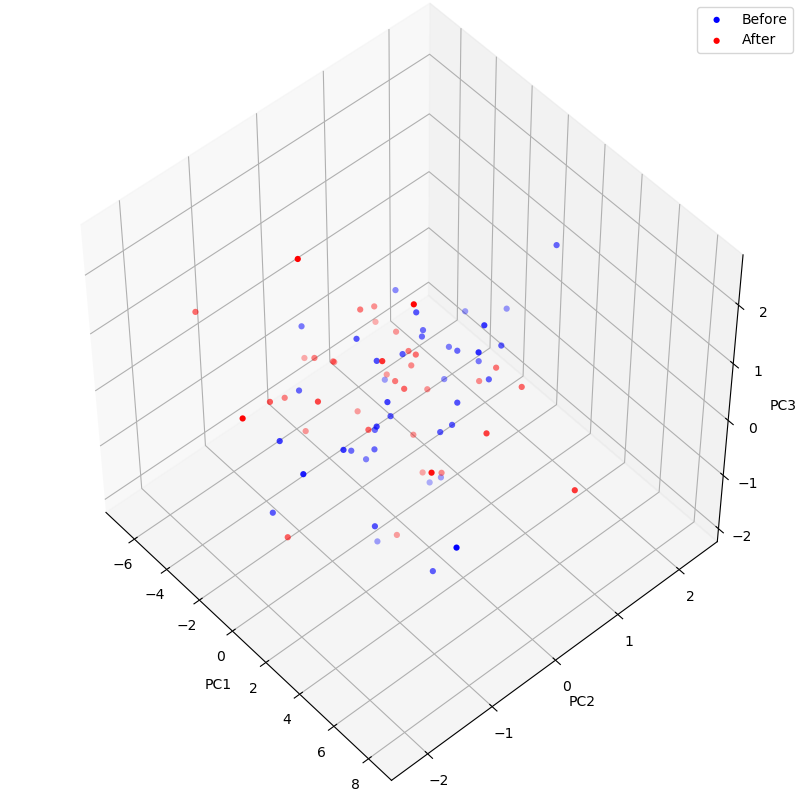

In [249]:
def plot_pca_3d(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='', label='Before')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='', label='After')
    # plt.title(title)
    plt.legend()
    plt.show()

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

# plot_pca_3d(df_bef, df_aft, df_bef['age'], df_aft['age'])
# plot_pca_3d(df_bef, df_aft, title="Before / After")
# plot_pca_3d(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
# plot_pca_3d(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")
plot_pca_3d(df_resp.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'a'), :], title='Resp / Non')

<IPython.core.display.Javascript object>


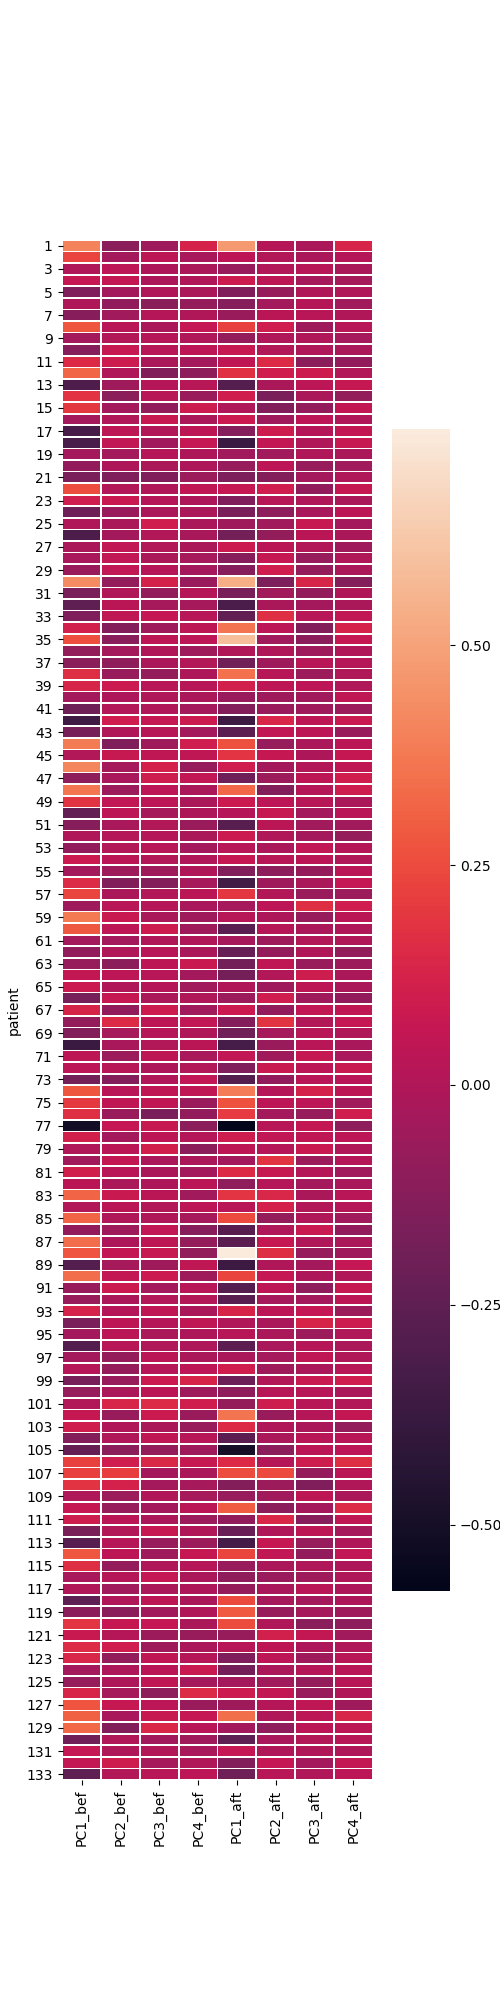

In [93]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def plot_heatmap(df_bef=df_bef, df_aft=df_aft, n=3, title='All'):

    pca = decomposition.PCA(n_components=4)
    pca.fit(df[CHANNEL_NAMES])
    bef_proj_df = pd.DataFrame(pca.transform(df_bef[CHANNEL_NAMES]), index=df_bef.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    aft_proj_df = pd.DataFrame(pca.transform(df_aft[CHANNEL_NAMES]), index=df_aft.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

    joined_df = bef_proj_df.join(aft_proj_df, lsuffix='_bef', rsuffix='_aft')

    plt.figure(figsize=(5, 20))
    ax = sns.heatmap(joined_df, linewidth=0.5)
    # plt.title(": ".join((measure, title)))
    plt.show()
    # plt.savefig(os.path.join(VISUAL_ROOT, "heatmaps", _".join((measure, title))+'.png'))

# for measure in ('lyap', 'corr', 'sampen'):
for measure in ('higu',):
    df, df_bef, df_aft = prepare_dfs(measure)
    plot_heatmap()
    # plot_heatmap(df_bef[df_bef['sex']==0], df_aft[df_aft['sex']==0], title='Women')
    # plot_heatmap(df_bef[df_bef['sex']==1], df_aft[df_aft['sex']==1], title='Men')
    # plot_heatmap(df_bef[df_bef['age']>50], df_aft[df_aft['age']>50], title='Age >= 50')
    # plot_heatmap(df_bef[df_bef['age']<=30], df_aft[df_aft['age']<=30], title='Age <= 30')
    # plot_heatmap(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1], title='Responding')
    # plot_heatmap(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0], title='Non-responding')
    # plot_heatmap(df_bef[df_bef['sc_bef']<25], df_aft[df_aft['sc_bef']<25], title='Score before < 25')
    # plot_heatmap(df_bef[df_bef['sc_bef']>=30], df_aft[df_aft['sc_bef']>=30], title='Score before >= 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']<25], df_aft[df_aft['sc_aft']<25], title='Score after < 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']>=30], df_aft[df_aft['sc_aft']>=30], title='Score after >= 25')
    

# Other ideas

<IPython.core.display.Javascript object>


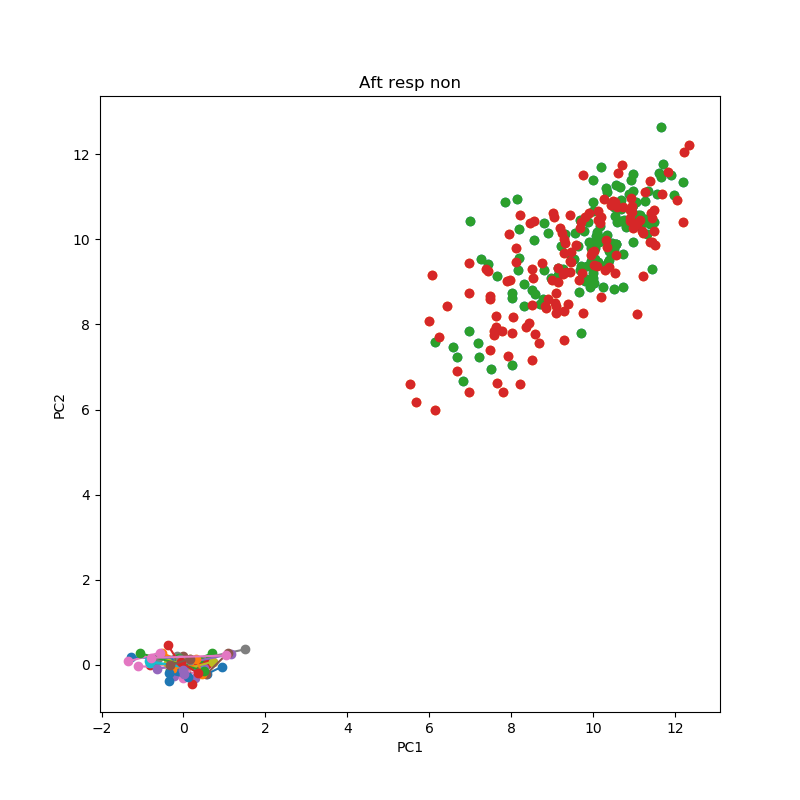

MEAN DISTANCE: 0.7337126493804711


In [21]:
# Plot PCA, but same people with the same color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from math import sqrt

def plot_pca_pairs_2d(df_first, df_second, title=""):
    pca = decomposition.PCA(n_components=2)
    # pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    pca.fit(df[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    dists = []
    cmap = plt.get_cmap('gnuplot')
    for i in range(min(len(first), len(second))):
        xs = [first[i, 0], second[i, 0]]
        ys = [first[i, 1], second[i, 1]]
        dists.append(sqrt((first[i,0]-second[i,0])**2 + (first[i,1]-second[i,1])**2))
        # plt.plot(xs, ys, 'o-', color=cmap())
        plt.plot(xs, ys, 'o-')
    print("MEAN DISTANCE: {}".format(sum(dists)/len(dists)))
        
    plt.title(title)
    plt.show()

col = 'dfa'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

# plot_pca_pairs_2d(df_bef, df_aft, title="")
# plot_pca_pairs_2d(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :], title='Resp bef aft')
# plot_pca_pairs_2d(df_non.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'b'), :], title='Non bef aft')

In [21]:
# For each person, plot their distance between before / after
from math import sqrt

def filter_by_distance(df_first, df_second, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    dists = []
    for fr, sr in zip(first, second):
        dists.append(sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)])))
    perc = np.percentile(dists, 90)
    df = pd.DataFrame()
    for i, (fr, sr) in enumerate(zip(first, second)):
        dist = sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)]))
        if dist > perc:
            df = df.append(df_first.iloc[i, :]) 
    print(df.loc[:, ['resp', 'age', 'sex', 'sc_bef', 'sc_aft', 'change']])
    

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

filter_by_distance(df_bef, df_aft)
filter_by_distance(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :])
filter_by_distance(df_non.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'b'), :])

     resp   age  sex  sc_bef  sc_aft    change
1     1.0  49.0  0.0    26.0    13.0  2.000000
20    1.0  49.0  0.0    27.0    13.0  2.076923
28    1.0  57.0  1.0    34.0    10.0  3.400000
62    1.0  34.0  0.0    23.0    10.0  2.300000
72    0.0  55.0  0.0    23.0    18.0  1.277778
102   1.0  56.0  1.0    18.0     6.0  3.000000
114   1.0  55.0  0.0    25.0    12.0  2.083333
123   0.0  54.0  1.0    24.0    25.0  0.960000
124   0.0  52.0  0.0    30.0    23.0  1.304348
127   0.0  35.0  0.0    25.0    21.0  1.190476
129   1.0  38.0  0.0    27.0     6.0  4.500000
          resp   age  sex  sc_bef  sc_aft    change
(62, a)    1.0  34.0  0.0    23.0    10.0  2.300000
(102, a)   1.0  56.0  1.0    18.0     6.0  3.000000
(114, a)   1.0  55.0  0.0    25.0    12.0  2.083333
(129, a)   1.0  38.0  0.0    27.0     6.0  4.500000
          resp   age  sex  sc_bef  sc_aft    change
(72, a)    0.0  55.0  0.0    23.0    18.0  1.277778
(123, a)   0.0  54.0  1.0    24.0    25.0  0.960000
(124, a)   0.0  52.0